In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import os

In [3]:
import datetime as dt
from datetime import date, timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

**inspect table name and column names**

In [6]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
columns_measure = inspector.get_columns('measurement')
for c in columns_measure:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
columns_station = inspector.get_columns('station')
for c in columns_station:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


**reflect database into a new model**

In [9]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [10]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
Measurement = Base.classes.measurement

In [12]:
Station = Base.classes.station

In [13]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data

### Precipitation Analysis

**Retrieve last 12 months of precipitation data and plot the results**

In [15]:
earliest_date = session.query(Measurement.date).order_by(Measurement.date).first()
earliest_date

('2010-01-01')

In [16]:
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date

('2017-08-23')

In [17]:
is_date = dt.datetime.strptime(*latest_date, "%Y-%m-%d")
is_date

datetime.datetime(2017, 8, 23, 0, 0)

In [18]:
one_year = is_date - timedelta(days=365)
one_year

datetime.datetime(2016, 8, 23, 0, 0)

In [19]:
# sorted by date ascending
one_year_ago = session.query(Measurement.date, Measurement.prcp) \
                      .filter(Measurement.date >= dt.datetime.strftime(one_year, "%Y-%m-%d")) \
                      .filter(Measurement.prcp.isnot(None)) \
                      .order_by(Measurement.date).all()
one_year_df  = pd.DataFrame(one_year_ago, columns = ['date', 'precipitation'])
one_year_df.set_index('date', inplace=True)
one_year_df

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


**sort by date**

In [20]:
one_year_df = one_year_df.sort_index()
one_year_df

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


In [21]:
one_year_df.isnull().values.any()

False

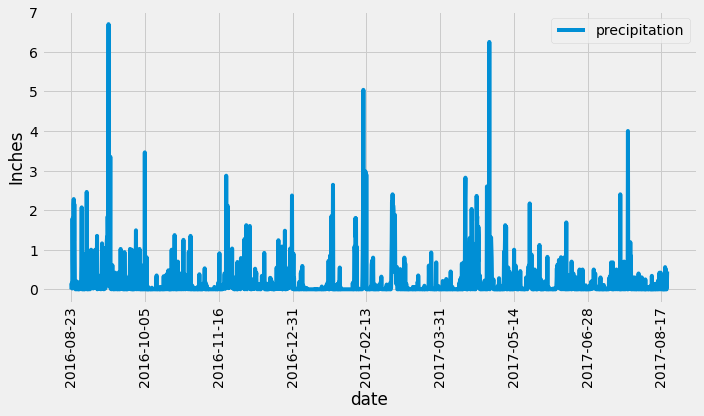

In [49]:
one_year_df.plot(figsize=(10,6))
plt.legend(loc='best')
plt.ylabel('Inches')
plt.xticks(rotation=90)
plt.tight_layout()
file = os.path.join("Images","precipitation.png")
plt.savefig(file)
plt.show()

**Summary Statistics**

In [23]:
# Use Pandas to calcualte the summary statistics for the precipitation data
one_year_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

**Total number of stations**

In [24]:
# Design a query to show how many stations are available in this dataset?
# sorted by date ascending

In [25]:
stn = session.query(Station.id, Station.station, Station.name).all()
stn

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US'),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US'),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 (4, 'USC00517948', 'PEARL CITY, HI US'),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US'),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US'),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US'),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US'),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US')]

**Number of stations in dataset**

In [26]:
stn_count = session.query(func.count(Station.station)).scalar()
stn_count

9

In [27]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_station = session.query(Measurement.station, Station.name, func.count(Station.id)) \
                  .filter(Measurement.station == Station.station) \
                  .group_by(Station.station, Station.name) \
                  .order_by(func.count(Station.id).desc()).all()
active_station

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

**most active station**

In [28]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active = session.query(Measurement.station, Station.name, func.count(Station.id)) \
                  .filter(Measurement.station == Station.station) \
                  .group_by(Station.station, Station.name) \
                  .order_by(func.count(Station.id).desc()).first()
most_active

('USC00519281', 'WAIHEE 837.5, HI US', 2772)

In [29]:
most_active.station

'USC00519281'

**lowest, highest, and average temperature recorded of the most active station**

In [30]:
recorded = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)) \
                  .filter(Measurement.station == most_active.station) \
                  .all()

recorded_min = recorded[0][0]
print(f'lowest temperature {recorded_min}')
recorded_max = recorded[0][1]
print(f'highest temperature {recorded_max}')
recorded_avg = recorded[0][2]
print(f'average temperature {recorded_avg}')

lowest temperature 54.0
highest temperature 85.0
average temperature 71.66378066378067


**station with the highest number of temperature observations**

In [31]:
highest_tobs = session.query(Measurement.station, func.count(Measurement.tobs)) \
                      .group_by(Measurement.station) \
                      .order_by(func.count(Measurement.tobs).desc()) \
                      .first()
highest_tobs

('USC00519281', 2772)

In [32]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
one_year_tobs = session.query(Measurement.date, Measurement.tobs) \
                      .filter(Measurement.date >= dt.datetime.strftime(one_year, "%Y-%m-%d")) \
                      .filter(Measurement.station == highest_tobs.station) \
                      .order_by(Measurement.date).all()
one_year_tobs
tobs_df  = pd.DataFrame(one_year_tobs, columns = ['date', 'tobs'])
tobs_df['date'] = pd.to_datetime(tobs_df['date'])
tobs_df.set_index('date', inplace=True)
tobs_df


,tobs
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


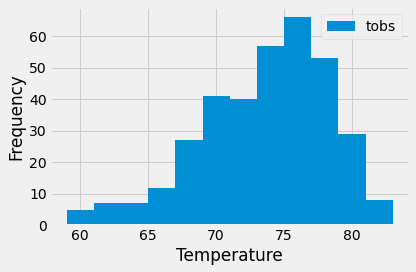

In [33]:
tobs_df.hist(bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(["tobs"])
plt.title("")
plt.tight_layout()
file = os.path.join("Images","histogram.png")
plt.savefig(file)
plt.show()

## Bonus Challenge Assignment

# Temperature Analysis I

**Identify the average temperature in June at all stations across all available years in the dataset.**

In [34]:
june_temps = session.query(func.strftime("%Y-%m", Measurement.date), func.avg(Measurement.tobs)) \
                    .filter(func.strftime("%m",Measurement.date) == '06') \
                    .group_by(func.strftime("%Y",Measurement.date)) \
                    .all()
june_temps

[('2010-06', 74.92561983471074),
 ('2011-06', 73.93832599118943),
 ('2012-06', 74.0),
 ('2013-06', 74.59907834101382),
 ('2014-06', 75.02790697674419),
 ('2015-06', 74.99014778325123),
 ('2016-06', 75.17525773195877),
 ('2017-06', 77.21989528795811)]

**Do the same for December temperature**

In [35]:
dec_temps = session.query(func.strftime("%Y-%m", Measurement.date), func.avg(Measurement.tobs)) \
                    .filter(func.strftime("%m",Measurement.date) == '12') \
                    .group_by(func.strftime("%Y",Measurement.date)) \
                    .all()
dec_temps

[('2010-12', 70.20851063829787),
 ('2011-12', 70.82062780269058),
 ('2012-12', 71.18807339449542),
 ('2013-12', 71.09401709401709),
 ('2014-12', 69.89686098654708),
 ('2015-12', 73.42391304347827),
 ('2016-12', 71.13)]

In [36]:
june = [temp[1] for temp in june_temps]
dec = [temp[1] for temp in dec_temps]

# t-test

**use paired t-test, compares means of temperature observation at two different times of the year**

In [37]:
from scipy import stats
t, p = stats.ttest_ind(june, dec)
p = "{:.10f}".format(p)
print(f"t: {t}    p: {p}")

t: 6.97605237788662    p: 0.0000096815


# Temperature Analysis II

In [38]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


**calc_temps for dates July 1 - 15, 2017 (trip is in 2018 on the same dates)**

In [39]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
july_trip = calc_temps('2017-07-01', '2017-0715')
print(f"TMIN: {july_trip[0][0]}")
print(f"TAVG: {july_trip[0][1]}")
print(f"TMAX: {july_trip[0][2]}")

TMIN: 69.0
TAVG: 78.48453608247422
TMAX: 87.0


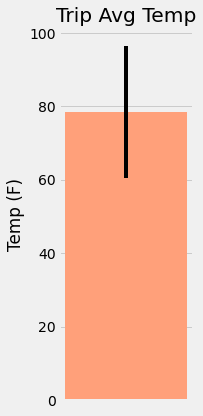

In [40]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr = july_trip[0][2] - july_trip[0][0]

fig, ax = plt.subplots(figsize=(3,6))
ax.set(xticks= [], ylabel = 'Temp (F)', title='Trip Avg Temp')
ax.bar(1, july_trip[0][1], yerr=yerr, align="center", color = 'lightsalmon')

plt.tight_layout()
file = os.path.join("Images","trip_avg_temp.png")
plt.savefig(file)

plt.show()

**Daily Rainfall Average**

In [41]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall = session.query(Measurement.station, func.sum(Measurement.prcp),
                         Station.name, Station.latitude, Station.longitude, Station.elevation) \
                  .filter(Measurement.station == Station.station) \
                  .filter(Measurement.date >= '2017-07-01') \
                  .filter(Measurement.date <= '2017-07-15') \
                  .group_by(Measurement.station) \
                  .order_by(func.sum(Measurement.prcp).desc()) \
                  .all()
rainfall

[('USC00516128',
  2.8700000000000006,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 ('USC00519281',
  1.6400000000000001,
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00513117',
  0.8300000000000001,
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6),
 ('USC00514830',
  0.39,
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00519397', 0.21, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00519523',
  0.13,
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00517948', None, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]

In [42]:
columns = ['station', 'rainfall', 'name', 'latitude', 'longitude', 'elevation' ]
rainfall_df = pd.DataFrame(rainfall, columns=columns)
rainfall_df

,station,rainfall,name,latitude,longitude,elevation
0,USC00516128,2.87,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00519281,1.64,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00513117,0.83,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00514830,0.39,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
4,USC00519397,0.21,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
5,USC00519523,0.13,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,USC00517948,NaN,"PEARL CITY, HI US",21.39340,-157.97510,11.9


In [43]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

**Daily normals for my trip**

In [44]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2018-07-01'
end_date = '2018-07-15'
# Use the start and end date to create a range of dates
trip_dates = pd.date_range(start = start_date, end = end_date, periods = 15)

# Stip off the year and save a list of %m-%d strings
days = list(np.ravel(pd.to_datetime(trip_dates).strftime("%m-%d")))
days

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
tmin = []
tavg = []
tmax = []

for x in range(len(days)):
    normals.append(daily_normals(days[x]))

tmin = [item[0][0] for item in normals]
tavg = [item[0][1] for item in normals]
tmax = [item[0][2] for item in normals]


In [45]:
trip_dates = list(np.ravel(pd.to_datetime(trip_dates).strftime("%Y-%m-%d")))
trip_dates

['2018-07-01',
 '2018-07-02',
 '2018-07-03',
 '2018-07-04',
 '2018-07-05',
 '2018-07-06',
 '2018-07-07',
 '2018-07-08',
 '2018-07-09',
 '2018-07-10',
 '2018-07-11',
 '2018-07-12',
 '2018-07-13',
 '2018-07-14',
 '2018-07-15']

In [46]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
data = {'Date' : trip_dates, 'tmin' : tmin, 'tavg' : tavg, 'tmax' : tmax}
daily_temps = pd.DataFrame(data)
daily_temps.set_index('Date', inplace = True)
daily_temps

,tmin,tavg,tmax
Date,,,
2018-07-01,67.0,74.777778,81.0
2018-07-02,68.0,75.403846,82.0
2018-07-03,68.0,75.320755,87.0
2018-07-04,70.0,76.571429,81.0
2018-07-05,66.0,75.000000,81.0
2018-07-06,69.0,75.000000,81.0
2018-07-07,69.0,74.910714,82.0
2018-07-08,69.0,76.083333,83.0
2018-07-09,68.0,76.192982,83.0


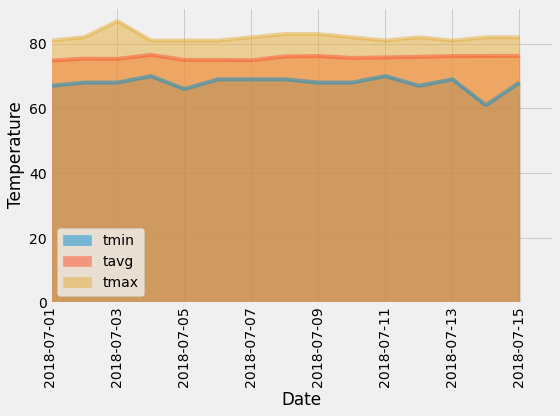

In [47]:
# Plot the daily normals as an area plot with `stacked=False`
ax = daily_temps.plot.area(stacked=False, figsize=(8,6))
plt.ylabel('Temperature')
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend(loc='lower left')
plt.xlim(0,len(days))

file = os.path.join("Images","daily_normals.png")
plt.savefig(file)

plt.show()

In [48]:
session.close()